In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_nuvals import WMSE
from pitchfuncs_nuvals import InversePCA
from pitchfuncs_nuvals import emulator
from pitchfuncs_nuvals import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
import astropy.constants


def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())


2024-04-19 13:23:45.026949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 13:23:45.026976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 13:23:45.027801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 13:23:45.031996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 13:23:45.544641: W tensorflow/compiler/tf2

In [2]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [3]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]

model = model.sample(n=1, random_state=42)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['calc_Teff', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(5,40)]

model['calc_Teff'] = calc_Teff(model['luminosity'], model['radius'])

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,star_feh,nu_0_4,...,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,log_calc_effective_T_std,calc_Teff
5582286,1.08,0.019516,0.3,2.1,5.118196,1.267858,1.758513,5907.183958,0.113077,506.602865,...,0.025529,0.024205,0.021714,0.018115,0.014499,0.012547,0.01199,0.01251,0.111886,5903.066257


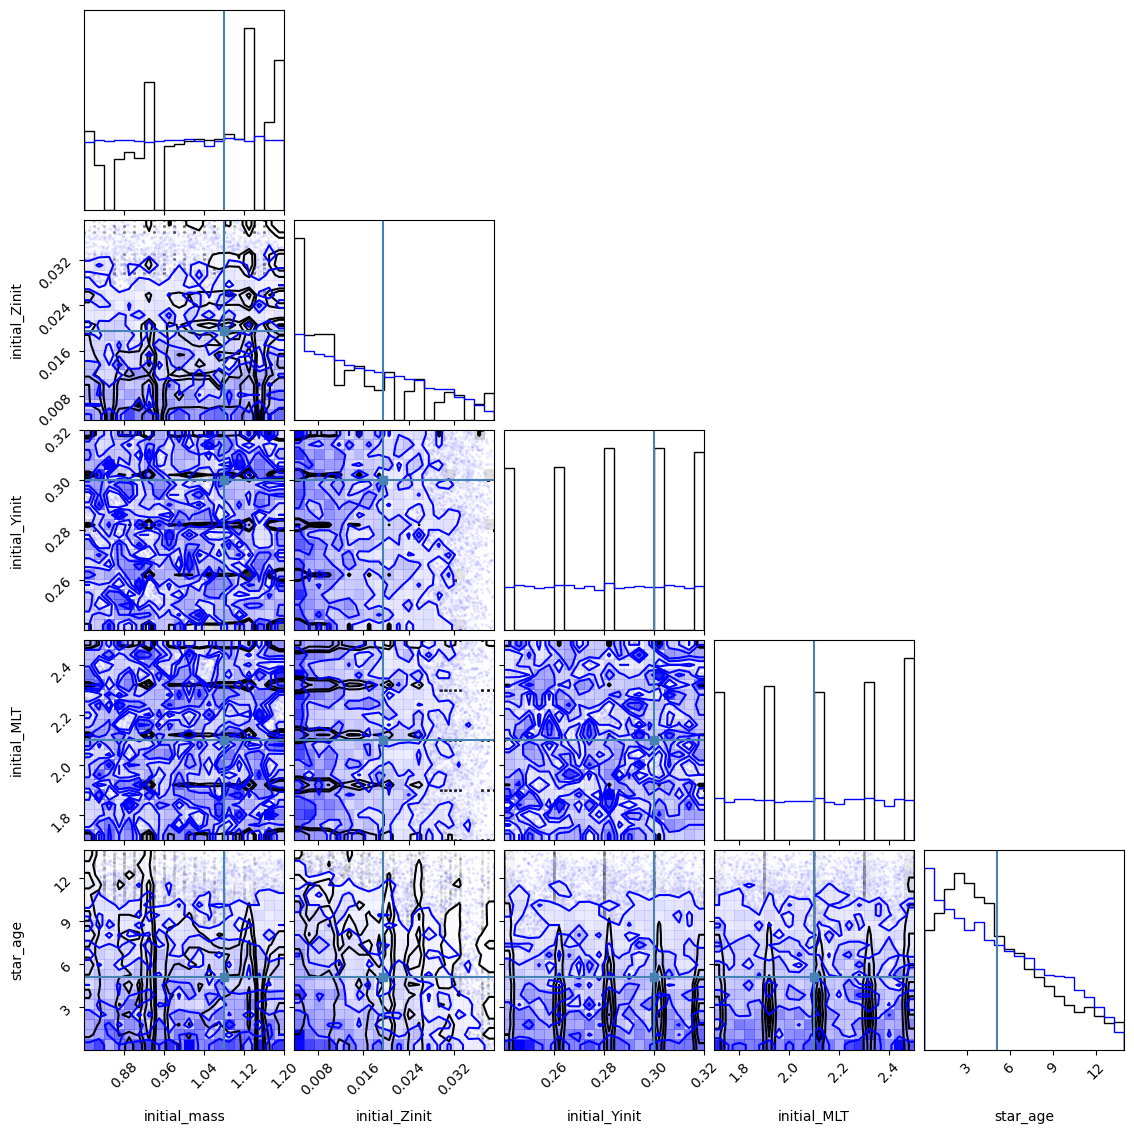

In [4]:
"""
Define priors
"""

def grid_uniform_prior(df, header):
    df_min = df[header].min()
    return scipy.stats.uniform(loc=df_min, scale=df[header].max()-df_min)

def uniform_prior(model_inps, header, scale=0.1):
    model_min = model_inps[header]*(1-scale)
    return scipy.stats.uniform(loc=model_min, scale=(model_inps[header]*(1+scale))-model_min)

def normal_prior(model_inps, header, scale=0.1):
    loc=model_inps[header].values[0]
    return scipy.stats.norm(loc=loc, scale=scale*loc)

def beta_prior(df, header,a=1,b=1):
    df_min = df[header].min()
    return scipy.stats.beta(loc=df_min, scale=df[header].max()-df_min, a=a, b=b)

mass_prior = grid_uniform_prior(df, "initial_mass")

Zinit_prior = beta_prior(df,"initial_Zinit",a=0.9, b=1.5)

Yinit_prior = grid_uniform_prior(df, "initial_Yinit")

MLT_prior = grid_uniform_prior(df, "initial_MLT")

age_prior = beta_prior(df, "star_age", a=0.9, b=1.5)


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000), hist_kwargs={'density':True});

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure,hist_kwargs={'density':True});

In [5]:
pitchfork = emulator("nu6-40_elu_nonorm_feh")

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


2024-04-19 13:23:52.052430: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-19 13:23:52.052453: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-04-19 13:23:52.052458: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-04-19 13:23:52.052556: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-04-19 13:23:52.052575: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-04-19 13:23:52.052579: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.161.7 does not match DSO version 535.171.4 -- cannot find working devices in this configuration


In [12]:
"""
Define observed quantities and uncertainties
"""
obs = np.concatenate((model_outs.values[0][:3],model_outs.values[0][[20]]))
unc = np.array([70,0.02,.1,1])
unc

array([7.e+01, 2.e-02, 1.e-01, 1.e+00])

In [13]:
obs

array([5.90306626e+03, 1.75851280e+00, 1.13076790e-01, 2.40613125e+03])

In [14]:
"""
add noise to observed quantities
"""
def obs_noise(obs, unc):
    noisy_obs = np.empty(len(obs))
    idx = 0
    for ob in obs:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs()
        idx+=1

    return noisy_obs

noisy_obs = obs_noise(obs,unc)

print(noisy_obs-obs)
print(obs)
print(noisy_obs)
print(unc)

[-1.27305474e+02  4.36214068e-04 -1.02418633e-01 -6.78546513e-01]
[5.90306626e+03 1.75851280e+00 1.13076790e-01 2.40613125e+03]
[5.77576078e+03 1.75894901e+00 1.06581577e-02 2.40545271e+03]
[7.e+01 2.e-02 1.e-01 1.e+00]


In [ ]:
df_test = pd.read_hdf('/home/oxs235/repos/ojscutt/sl-pitchfork/test_data.h5', key='df')

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())

df_test['calc_Teff'] = calc_Teff(df_test['luminosity'], df_test['radius'])

preds=np.empty((len(outputs),len(df_test)))

for i in range(len(df_test)):
    pred = pitchfork.predict(np.array([df_test[inputs].iloc[i].values]))
    preds[:,i] = pred
    print(f'{i}', end='\r')

emulator_unc = scipy.stats.median_abs_deviation(df_test[['calc_Teff', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(5,40)]].values - preds.T)

print(len(unc))
print(len(emulator_unc))

combined_unc = np.sqrt(unc**2 + emulator_unc**2)
df_test['calc_Teff']

In [ ]:
emulator_unc = scipy.stats.median_abs_deviation(df_test[['calc_Teff', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(5,40)]].values - preds.T)

print(len(unc))
print(len(emulator_unc))

combined_unc = np.sqrt(unc**2 + emulator_unc**2)
emulator_unc

In [16]:
emulator_unc = np.array([2.17481885e+00, 1.49321010e-03, 0.0004036,3.20503871e-01])

combined_unc = np.sqrt(unc**2 + emulator_unc**2)
emulator_unc
combined_unc

array([7.00337764e+01, 2.00556644e-02, 1.00000814e-01, 1.05010606e+00])

iter: 3343 | +250 | bound: 65 | nc: 1 | ncall: 70715 | eff(%):  5.099 | loglstar:   -inf < -1.721 <    inf | logz: -13.635 +/-  0.208 | dlogz:  0.001 >  0.259                                        

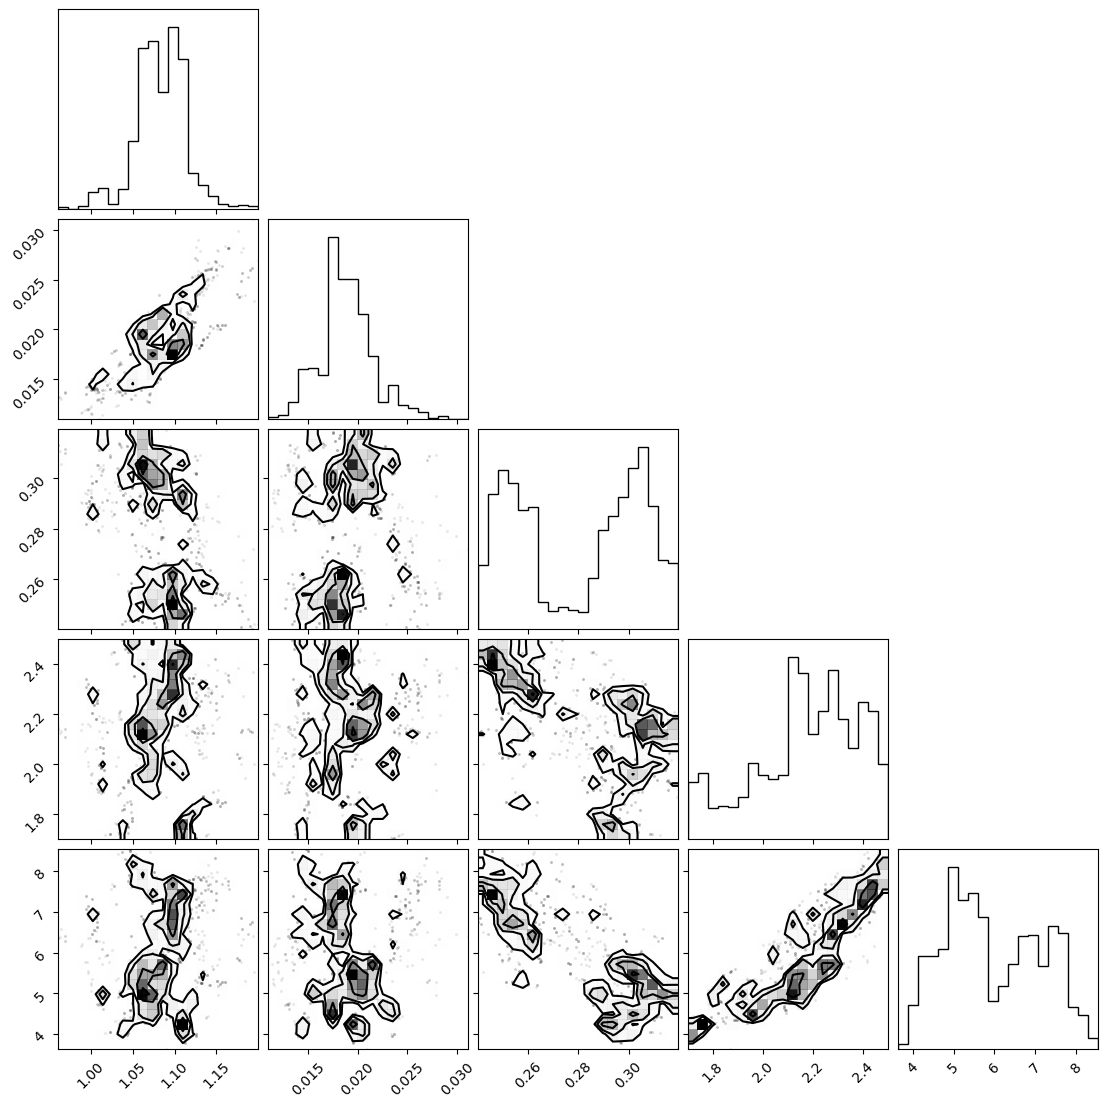

In [17]:
"""
run with emulator noise
"""


tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1, n_vals=[23])
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

corner.corner(posterior);

iter: 3354 | +250 | bound: 31 | nc: 1 | ncall: 130897 | eff(%):  2.759 | loglstar:   -inf < -1.747 <    inf | logz: -13.713 +/-  0.207 | dlogz:  0.001 >  0.259                                       

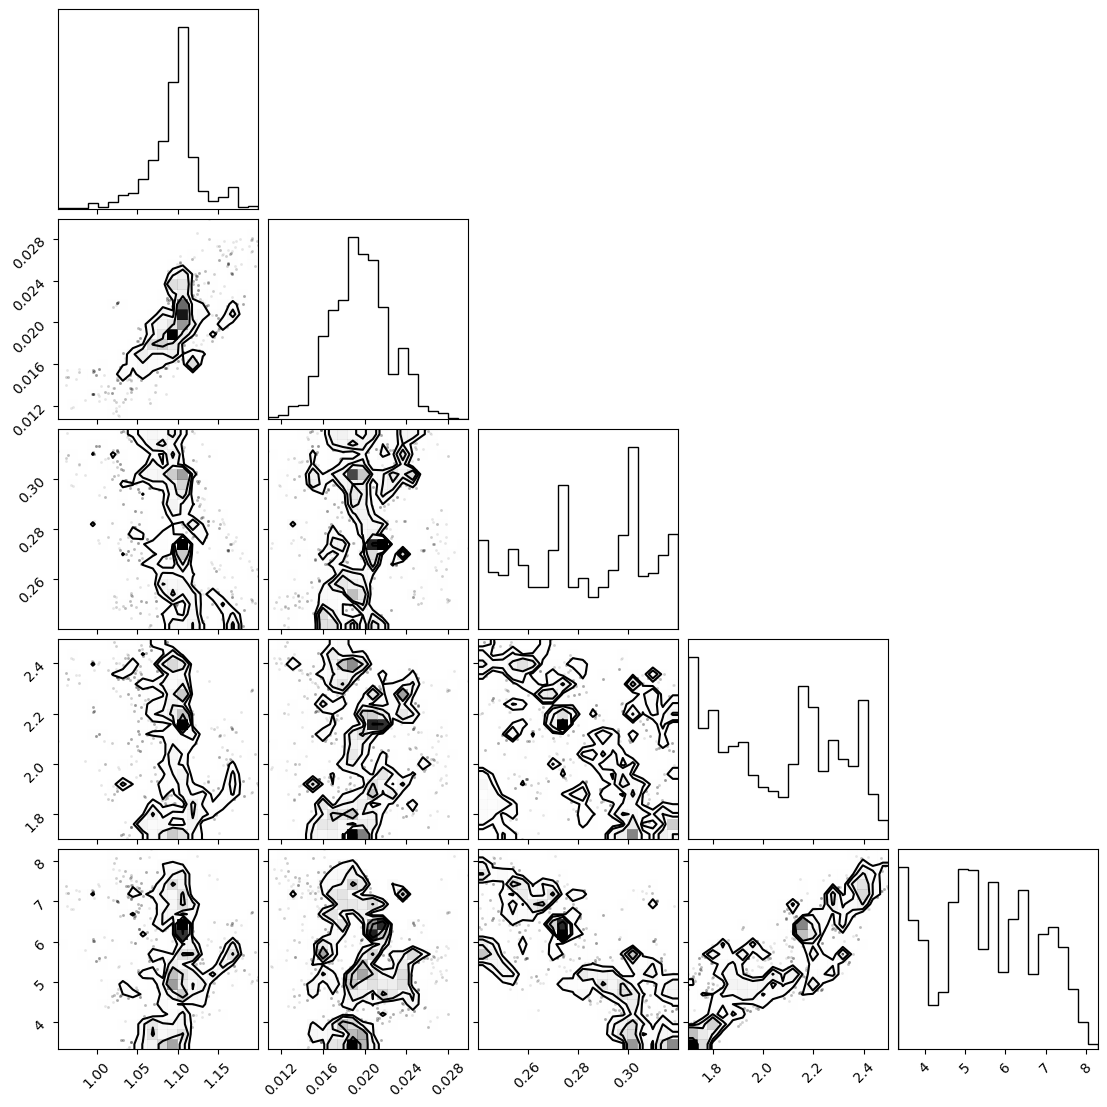

In [18]:
"""
run with emulator noise
"""


tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1, n_vals=[23])
posterior = sampler(nlive=250,sample='rslice', bound='multi')
toc = time.time()

corner.corner(posterior);

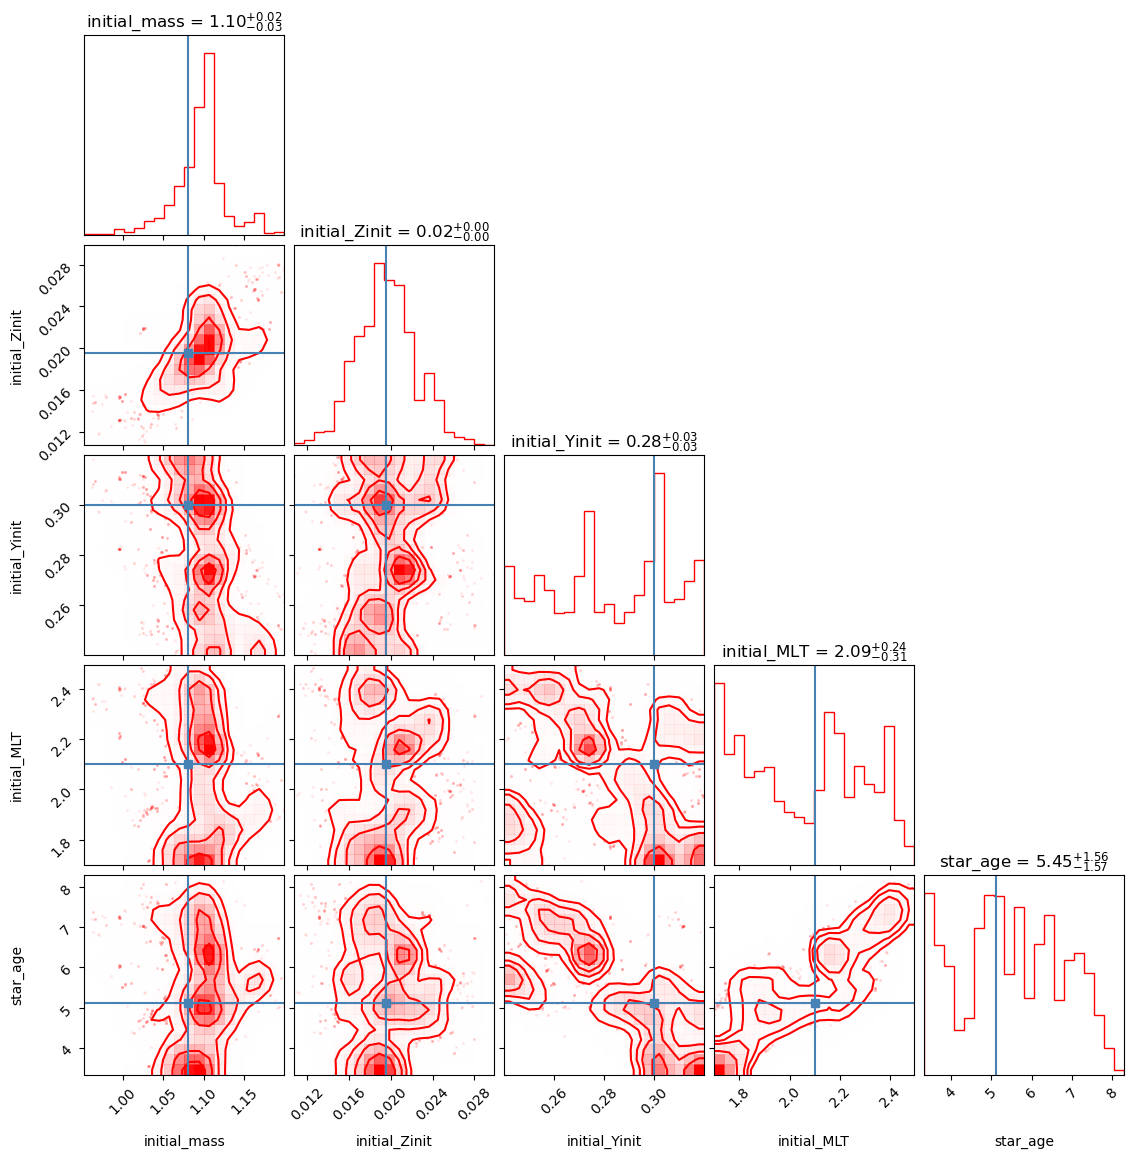

In [19]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

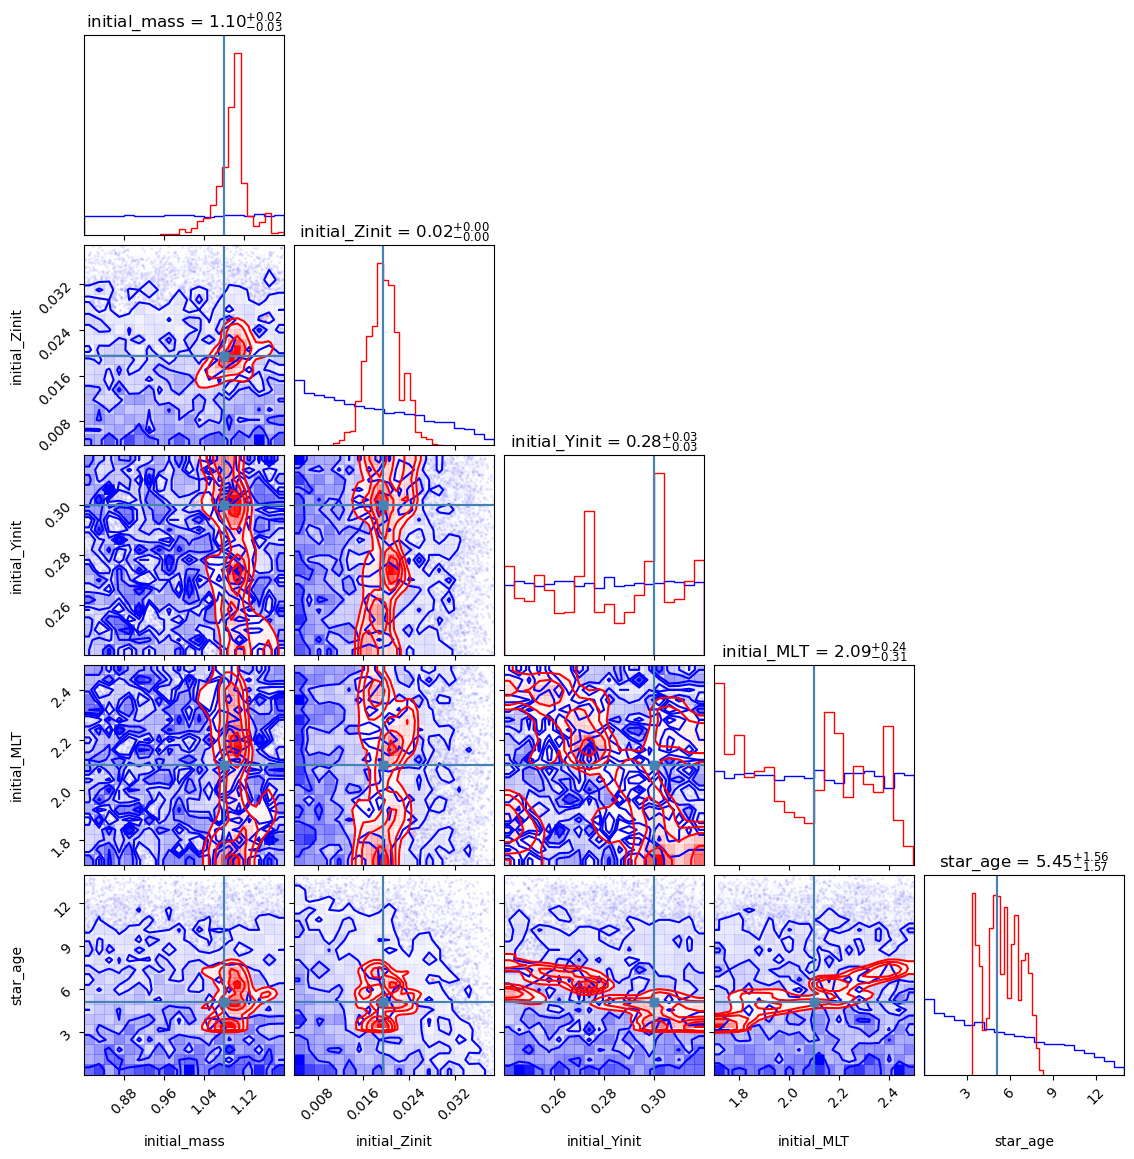

In [20]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True});


In [ ]:
"""
run with emulator noise
"""

tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=combined_unc, pitchfork=pitchfork)
posterior = sampler(nlive=1000,sample='rwalk', bound='multi')
toc = time.time()

corner.corner(posterior);

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True});


In [ ]:
"""
run with obs noise added
"""
noisy_obs = obs_noise(obs,unc)

posteriors_dict = {'posterior_0' : posterior}

for i in range(1,5):
    print(f'current iteration: {i}', end='\r')
    noisy_obs = obs_noise(obs,unc)
    sampler = ns(priors=priors, observed_vals=noisy_obs, observed_unc=combined_unc, pitchfork=pitchfork)
    posterior_i = sampler(nlive=500,sample='rwalk', bound='multi')
    posteriors_dict[f'posterior_{i}'] = posterior_i
    

In [ ]:
idx = 0
for posterior_i in posteriors_dict:
    if idx == 0:
        figure = corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True,hist_kwargs={'density':True})
    elif idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

idx = 0
for posterior_i in posteriors_dict:
    if idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
idx = 0
for posterior_i in posteriors_dict:
    if idx == 0:
        figure = corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True,hist_kwargs={'density':True})
    elif idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

idx = 0
for posterior_i in posteriors_dict:
    if idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
len(posteriors_dict)

In [ ]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));
print(toc-tic)
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

In [ ]:
#prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});
#hist_kwargs={'density'=True}

In [ ]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

In [ ]:
%timeit pitchfork.predict([[0.1,0.1,0.1,0.1,0.1]])

In [19]:
m=pitchfork.predict([[0.1,0.1,0.1,0.1,0.1]])
np.concatenate((m[0][:3],m[0][[24,25,26]]))

array([9.14680888e+02, 3.81720599e-04, 1.64272192e+00, 8.35505337e+03,
       1.02245539e+04, 3.39939234e+04])

In [16]:
outputs

['calc_Teff',
 'luminosity',
 'star_feh',
 'nu_0_6',
 'nu_0_7',
 'nu_0_8',
 'nu_0_9',
 'nu_0_10',
 'nu_0_11',
 'nu_0_12',
 'nu_0_13',
 'nu_0_14',
 'nu_0_15',
 'nu_0_16',
 'nu_0_17',
 'nu_0_18',
 'nu_0_19',
 'nu_0_20',
 'nu_0_21',
 'nu_0_22',
 'nu_0_23',
 'nu_0_24',
 'nu_0_25',
 'nu_0_26',
 'nu_0_27',
 'nu_0_28',
 'nu_0_29',
 'nu_0_30',
 'nu_0_31',
 'nu_0_32',
 'nu_0_33',
 'nu_0_34',
 'nu_0_35',
 'nu_0_36',
 'nu_0_37',
 'nu_0_38',
 'nu_0_39',
 'nu_0_40']

In [ ]:
import pickle
file_path = "pickle jar/nu6-40_elu_nonorm"

with open(file_path+".pkl", 'rb') as fp:
    emulator_dict = pickle.load(fp)
    
custom_objects = {"InversePCA": InversePCA(emulator_dict['custom_objects']['inverse_pca']['pca_comps'], emulator_dict['custom_objects']['inverse_pca']['pca_mean']),"WMSE": WMSE(emulator_dict['custom_objects']['WMSE']['weights'])}

model = tf.keras.models.load_model(file_path+".h5", custom_objects=custom_objects)

In [ ]:
%timeit model(np.array([[0.1,0.1,0.1,0.1,0.1]]))